<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/Image/retinanet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6014, done.
remote: Total 6014 (delta 0), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6014/6014), 13.44 MiB | 28.31 MiB/s, done.
Resolving deltas: 100% (4061/4061), done.


In [ ]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=171486 sha256=36c15d65e775ca180dec17e6b741c06dec8b9e4da02e9cb1f4937f2ee3109c4d
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=24ac8f4fd0598b77a1f07adc832bb3dbbba5d20c1656988e596a825342eaa9ef
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [ ]:
path_annotations="/content/drive/My Drive/Glass/annotations/"
path_images = "/content/drive/My Drive/Glass/images/"

In [ ]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(path_annotations) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(path_annotations, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(path_annotations, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)


In [ ]:

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

### 1. Installing Darknet

In [ ]:
!git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5913, done.
remote: Total 5913 (delta 0), reused 0 (delta 0), pack-reused 5913
Receiving objects: 100% (5913/5913), 6.34 MiB | 12.50 MiB/s, done.
Resolving deltas: 100% (3917/3917), done.


In [ ]:
import os

# changing our working directory to ‘darknet’ 
os.chdir("/content/darknet")

In [ ]:
!ls

cfg	  include	LICENSE.gen   LICENSE.mit  python     src
data	  LICENSE	LICENSE.gpl   LICENSE.v1   README.md
examples  LICENSE.fuck	LICENSE.meta  Makefile	   scripts


In [ ]:
# To install Darknet for our session, we fetch the Makefile and run the following

!sed -i 's/GPU=0/GPU=1/g' Makefile
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/utils.c -o obj/utils.o


### 2. Downloading YOLOv1 model weights

In [ ]:
!wget http://pjreddie.com/media/files/yolov1/yolov1.weights

--2020-08-28 10:26:34--  http://pjreddie.com/media/files/yolov1/yolov1.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/yolov1/yolov1.weights [following]
--2020-08-28 10:26:35--  https://pjreddie.com/media/files/yolov1/yolov1.weights
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789312988 (753M) [application/octet-stream]
Saving to: ‘yolov1.weights’

yolov1.weights      100%[===================>] 752.75M   468KB/s    in 34m 40s 

2020-08-28 11:01:16 (371 KB/s) - ‘yolov1.weights’ saved [789312988/789312988]



### 3. Playing with images

The /content/darknet/data directory will have lots of images for you to play with. Let’s try dog.jpg first, this is what it looks like

Let’s try and detect the objects in this image, and see what probabilities our model outputs

In [ ]:
!./darknet yolo test /content/darknet/cfg/yolov1.cfg /content/darknet/yolov1.weights /content/darknet/data/dog.jpg

layer     filters    size              input                output
    0 conv     64  7 x 7 / 2   448 x 448 x   3   ->   224 x 224 x  64  0.944 BFLOPs
    1 max          2 x 2 / 2   224 x 224 x  64   ->   112 x 112 x  64
    2 conv    192  3 x 3 / 1   112 x 112 x  64   ->   112 x 112 x 192  2.775 BFLOPs
    3 max          2 x 2 / 2   112 x 112 x 192   ->    56 x  56 x 192
    4 conv    128  1 x 1 / 1    56 x  56 x 192   ->    56 x  56 x 128  0.154 BFLOPs
    5 conv    256  3 x 3 / 1    56 x  56 x 128   ->    56 x  56 x 256  1.850 BFLOPs
    6 conv    256  1 x 1 / 1    56 x  56 x 256   ->    56 x  56 x 256  0.411 BFLOPs
    7 conv    512  3 x 3 / 1    56 x  56 x 256   ->    56 x  56 x 512  7.399 BFLOPs
    8 max          2 x 2 / 2    56 x  56 x 512   ->    28 x  28 x 512
    9 conv    256  1 x 1 / 1    28 x  28 x 512   ->    28 x  28 x 256  0.206 BFLOPs
   10 conv    512  3 x 3 / 1    28 x  28 x 256   ->    28 x  28 x 512  1.850 BFLOPs
   11 conv    256  1 x 1 / 1    28 x  28 x 512   ->

As seen above the probabilities are:
- dog: 26%
- car: 74%
- bicycle: 39%

The model saves the predictions to “predictions.jpg”, which you can view as follows

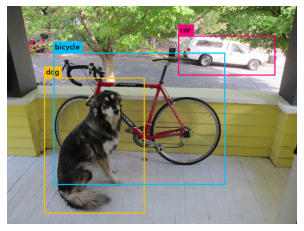

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os.path

fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

In [ ]:
!./darknet yolo test /content/darknet/cfg/yolov1.cfg /content/darknet/yolov1.weights /content/darknet/data/kite.jpg

layer     filters    size              input                output
    0 conv     64  7 x 7 / 2   448 x 448 x   3   ->   224 x 224 x  64  0.944 BFLOPs
    1 max          2 x 2 / 2   224 x 224 x  64   ->   112 x 112 x  64
    2 conv    192  3 x 3 / 1   112 x 112 x  64   ->   112 x 112 x 192  2.775 BFLOPs
    3 max          2 x 2 / 2   112 x 112 x 192   ->    56 x  56 x 192
    4 conv    128  1 x 1 / 1    56 x  56 x 192   ->    56 x  56 x 128  0.154 BFLOPs
    5 conv    256  3 x 3 / 1    56 x  56 x 128   ->    56 x  56 x 256  1.850 BFLOPs
    6 conv    256  1 x 1 / 1    56 x  56 x 256   ->    56 x  56 x 256  0.411 BFLOPs
    7 conv    512  3 x 3 / 1    56 x  56 x 256   ->    56 x  56 x 512  7.399 BFLOPs
    8 max          2 x 2 / 2    56 x  56 x 512   ->    28 x  28 x 512
    9 conv    256  1 x 1 / 1    28 x  28 x 512   ->    28 x  28 x 256  0.206 BFLOPs
   10 conv    512  3 x 3 / 1    28 x  28 x 256   ->    28 x  28 x 512  1.850 BFLOPs
   11 conv    256  1 x 1 / 1    28 x  28 x 512   ->

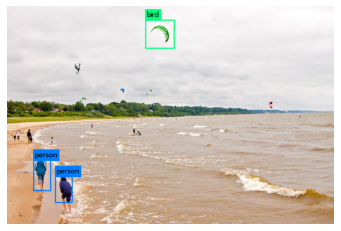

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

In [ ]:
!./darknet yolo test /content/darknet/cfg/yolov1.cfg /content/darknet/yolov1.weights /content/darknet/data/person.jpg

layer     filters    size              input                output
    0 conv     64  7 x 7 / 2   448 x 448 x   3   ->   224 x 224 x  64  0.944 BFLOPs
    1 max          2 x 2 / 2   224 x 224 x  64   ->   112 x 112 x  64
    2 conv    192  3 x 3 / 1   112 x 112 x  64   ->   112 x 112 x 192  2.775 BFLOPs
    3 max          2 x 2 / 2   112 x 112 x 192   ->    56 x  56 x 192
    4 conv    128  1 x 1 / 1    56 x  56 x 192   ->    56 x  56 x 128  0.154 BFLOPs
    5 conv    256  3 x 3 / 1    56 x  56 x 128   ->    56 x  56 x 256  1.850 BFLOPs
    6 conv    256  1 x 1 / 1    56 x  56 x 256   ->    56 x  56 x 256  0.411 BFLOPs
    7 conv    512  3 x 3 / 1    56 x  56 x 256   ->    56 x  56 x 512  7.399 BFLOPs
    8 max          2 x 2 / 2    56 x  56 x 512   ->    28 x  28 x 512
    9 conv    256  1 x 1 / 1    28 x  28 x 512   ->    28 x  28 x 256  0.206 BFLOPs
   10 conv    512  3 x 3 / 1    28 x  28 x 256   ->    28 x  28 x 512  1.850 BFLOPs
   11 conv    256  1 x 1 / 1    28 x  28 x 512   ->

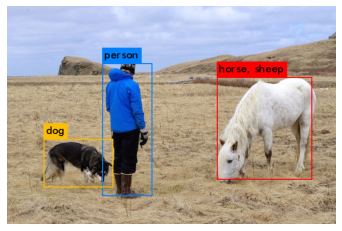

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

### Fast YOLO

In addition, along with YOLO v1, the authors also built a Fast YOLO model, which is designed to run at 155 FPS (more than 3 times faster than YOLO).

It also weighs considerably less — just 103 MB, compared to the 753 MB YOLO used.

let’s download its weights

In [ ]:
!wget http://pjreddie.com/media/files/yolov1/tiny-yolov1.weights

URL transformed to HTTPS due to an HSTS policy
--2020-08-28 11:23:13--  https://pjreddie.com/media/files/yolov1/tiny-yolov1.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108399816 (103M) [application/octet-stream]
Saving to: ‘tiny-yolov1.weights’

tiny-yolov1.weights 100%[===================>] 103.38M   449KB/s    in 4m 23s  

2020-08-28 11:27:37 (403 KB/s) - ‘tiny-yolov1.weights’ saved [108399816/108399816]



Let’s see what it does on person.jpg, whose objects YOLO didn’t quite correctly detect.

In [ ]:
!./darknet yolo test /content/darknet/cfg/yolov1-tiny.cfg /content/darknet/tiny-yolov1.weights /content/darknet/data/person.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   448 x 448 x   3   ->   448 x 448 x  16  0.173 BFLOPs
    1 max          2 x 2 / 2   448 x 448 x  16   ->   224 x 224 x  16
    2 conv     32  3 x 3 / 1   224 x 224 x  16   ->   224 x 224 x  32  0.462 BFLOPs
    3 max          2 x 2 / 2   224 x 224 x  32   ->   112 x 112 x  32
    4 conv     64  3 x 3 / 1   112 x 112 x  32   ->   112 x 112 x  64  0.462 BFLOPs
    5 max          2 x 2 / 2   112 x 112 x  64   ->    56 x  56 x  64
    6 conv    128  3 x 3 / 1    56 x  56 x  64   ->    56 x  56 x 128  0.462 BFLOPs
    7 max          2 x 2 / 2    56 x  56 x 128   ->    28 x  28 x 128
    8 conv    256  3 x 3 / 1    28 x  28 x 128   ->    28 x  28 x 256  0.462 BFLOPs
    9 max          2 x 2 / 2    28 x  28 x 256   ->    14 x  14 x 256
   10 conv    512  3 x 3 / 1    14 x  14 x 256   ->    14 x  14 x 512  0.462 BFLOPs
   11 max          2 x 2 / 2    14 x  14 x 512   ->     7 x   7 x 512
   12 con

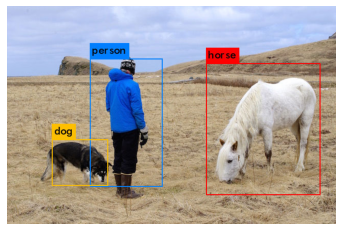

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

In [ ]:
os.chdir("/content")
from google.colab import files

uploaded = files.upload()

Saving one.jpeg to one.jpeg


In [ ]:
os.chdir("/content/darknet/")

!./darknet yolo test /content/darknet/cfg/yolov1-tiny.cfg /content/darknet/tiny-yolov1.weights /content/one.jpeg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   448 x 448 x   3   ->   448 x 448 x  16  0.173 BFLOPs
    1 max          2 x 2 / 2   448 x 448 x  16   ->   224 x 224 x  16
    2 conv     32  3 x 3 / 1   224 x 224 x  16   ->   224 x 224 x  32  0.462 BFLOPs
    3 max          2 x 2 / 2   224 x 224 x  32   ->   112 x 112 x  32
    4 conv     64  3 x 3 / 1   112 x 112 x  32   ->   112 x 112 x  64  0.462 BFLOPs
    5 max          2 x 2 / 2   112 x 112 x  64   ->    56 x  56 x  64
    6 conv    128  3 x 3 / 1    56 x  56 x  64   ->    56 x  56 x 128  0.462 BFLOPs
    7 max          2 x 2 / 2    56 x  56 x 128   ->    28 x  28 x 128
    8 conv    256  3 x 3 / 1    28 x  28 x 128   ->    28 x  28 x 256  0.462 BFLOPs
    9 max          2 x 2 / 2    28 x  28 x 256   ->    14 x  14 x 256
   10 conv    512  3 x 3 / 1    14 x  14 x 256   ->    14 x  14 x 512  0.462 BFLOPs
   11 max          2 x 2 / 2    14 x  14 x 512   ->     7 x   7 x 512
   12 con

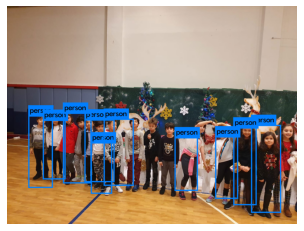

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

In [ ]:
os.chdir("/content")
from google.colab import files

uploaded = files.upload()

Saving two.jpeg to two.jpeg


In [ ]:
os.chdir("/content/darknet/")

!./darknet yolo test /content/darknet/cfg/yolov1-tiny.cfg /content/darknet/tiny-yolov1.weights /content/two.jpeg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   448 x 448 x   3   ->   448 x 448 x  16  0.173 BFLOPs
    1 max          2 x 2 / 2   448 x 448 x  16   ->   224 x 224 x  16
    2 conv     32  3 x 3 / 1   224 x 224 x  16   ->   224 x 224 x  32  0.462 BFLOPs
    3 max          2 x 2 / 2   224 x 224 x  32   ->   112 x 112 x  32
    4 conv     64  3 x 3 / 1   112 x 112 x  32   ->   112 x 112 x  64  0.462 BFLOPs
    5 max          2 x 2 / 2   112 x 112 x  64   ->    56 x  56 x  64
    6 conv    128  3 x 3 / 1    56 x  56 x  64   ->    56 x  56 x 128  0.462 BFLOPs
    7 max          2 x 2 / 2    56 x  56 x 128   ->    28 x  28 x 128
    8 conv    256  3 x 3 / 1    28 x  28 x 128   ->    28 x  28 x 256  0.462 BFLOPs
    9 max          2 x 2 / 2    28 x  28 x 256   ->    14 x  14 x 256
   10 conv    512  3 x 3 / 1    14 x  14 x 256   ->    14 x  14 x 512  0.462 BFLOPs
   11 max          2 x 2 / 2    14 x  14 x 512   ->     7 x   7 x 512
   12 con

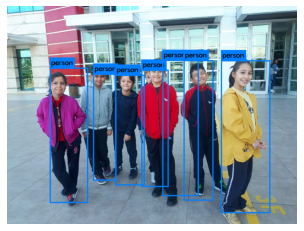

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

In [ ]:
os.chdir("/content")
from google.colab import files

uploaded = files.upload()

Saving three.jpeg to three.jpeg


In [ ]:
os.chdir("/content/darknet/")

!./darknet yolo test /content/darknet/cfg/yolov1-tiny.cfg /content/darknet/tiny-yolov1.weights /content/three.jpeg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   448 x 448 x   3   ->   448 x 448 x  16  0.173 BFLOPs
    1 max          2 x 2 / 2   448 x 448 x  16   ->   224 x 224 x  16
    2 conv     32  3 x 3 / 1   224 x 224 x  16   ->   224 x 224 x  32  0.462 BFLOPs
    3 max          2 x 2 / 2   224 x 224 x  32   ->   112 x 112 x  32
    4 conv     64  3 x 3 / 1   112 x 112 x  32   ->   112 x 112 x  64  0.462 BFLOPs
    5 max          2 x 2 / 2   112 x 112 x  64   ->    56 x  56 x  64
    6 conv    128  3 x 3 / 1    56 x  56 x  64   ->    56 x  56 x 128  0.462 BFLOPs
    7 max          2 x 2 / 2    56 x  56 x 128   ->    28 x  28 x 128
    8 conv    256  3 x 3 / 1    28 x  28 x 128   ->    28 x  28 x 256  0.462 BFLOPs
    9 max          2 x 2 / 2    28 x  28 x 256   ->    14 x  14 x 256
   10 conv    512  3 x 3 / 1    14 x  14 x 256   ->    14 x  14 x 512  0.462 BFLOPs
   11 max          2 x 2 / 2    14 x  14 x 512   ->     7 x   7 x 512
   12 con

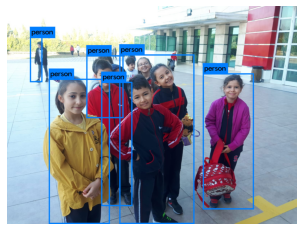

In [ ]:
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = '/content/darknet/predictions.jpg'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)